# Машинное обучение, ФКН ВШЭ

## Домашнее задание 1. Разложение ошибки на смещение и разброс. Бэггинг, бустинг.

### Общая информация

Дата выдачи: 15.09.2025

Дедлайн: 23:59MSK 28.09.2025


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# from sklearn.datasets import load_boston

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [ ]:
boston = load_boston()

In [ ]:
X = boston["data"]
y = boston["target"]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

In [3]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [4]:
X = data.copy()
y = target.copy()

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.932175246772296

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [20]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """

    size = X.shape[0]
    S = set(np.arange(0, size))
    predictions = np.zeros((size, num_runs))

    obj_bias = np.array([])
    obj_var = np.array([])
    obj_loss = np.array([])


    for i in range(num_runs):
      bootstrap_sample_idx = np.random.randint(0, size, size)
      bootstrap_sample = (X[bootstrap_sample_idx], y[bootstrap_sample_idx])
      bootstrap_sample_T = (X[list(S - set(bootstrap_sample_idx))], y[list(S - set(bootstrap_sample_idx))])
      regressor.fit(bootstrap_sample[0], bootstrap_sample[1])

      reg_pred = regressor.predict(bootstrap_sample_T[0])
      predictions[list(S - set(bootstrap_sample_idx)), i] = reg_pred

    for i in range(size):
      obj_preds = predictions[i][predictions[i] != 0]
      mean_preds = np.mean(obj_preds)

      obj_bias = np.append(obj_bias, [(mean_preds - y[i])**2])
      obj_var = np.append(obj_var, [np.mean((obj_preds - mean_preds)**2)])
      obj_loss = np.append(obj_loss, [np.mean((obj_preds - y[i])**2)])


    return np.mean(obj_bias), np.mean(obj_var), np.mean(obj_loss)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor(bootstrap=False)

print("Calculating reg1 bvd")
bias_1, var_1, loss_1 = compute_biase_variance(reg1, X, y)
print("Calculating reg2 bvd")
bias_2, var_2, loss_2 = compute_biase_variance(reg2, X, y)
print("Calculating reg3 bvd")
bias_3, var_3, loss_3 = compute_biase_variance(reg3, X, y)

Calculating reg1 bvd
Calculating reg2 bvd
Calculating reg3 bvd


In [22]:
bvd_df = pd.DataFrame({
    "model": ["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor"],
    "biase": [bias_1, bias_2, bias_3],
    "variance": [var_1, var_2, var_3],
    "loss": [loss_1, loss_2, loss_3]
    })
bvd_df

,model,biase,variance,loss
0,LinearRegression,23.707925,0.923003,24.630928
1,DecisionTreeRegressor,10.210158,13.076418,23.286576
2,RandomForestRegressor,10.333716,10.774297,21.108013


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Да, полученные результаты согласуются с тем, что мы обсуждали: у линейной модели низкий разброос, но высокий сдвиг, у решающего дерева наоборот, но все равно получше, а у случайного леса получше, но разброс, все равно большой

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Как можем заметить, для линейной регрессии разброс почти не изменился, но не увеличился, чего не скажешь об алгоритмах с деревьями, на них бэггинг повлиял положительно, а именно, уменьшил их разброс примерно в два раза, что не проверичит тому, что мы обсуждали

In [49]:
def calculate_bag_variance(bag, X, y):
    size = X.shape[0]
    predictions = np.array([estimator.predict(X)for estimator in bag.estimators_]).T
    obj_var = np.array([])

    for i in range(size):
      obj_preds = predictions[i]
      mean_preds = np.mean(obj_preds)

      obj_var = np.append(obj_var, [np.mean((obj_preds - mean_preds)**2)])

    return np.mean(obj_var)

In [38]:
from sklearn.ensemble import BaggingRegressor

reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor(bootstrap=False)

bag1 = BaggingRegressor(reg1, n_estimators=1000)
bag2 = BaggingRegressor(reg2, n_estimators=1000)
bag3 = BaggingRegressor(reg3, n_estimators=1000)

bag1.fit(X,y)
bag2.fit(X,y)
bag3.fit(X,y)

BaggingRegressor(estimator=RandomForestRegressor(bootstrap=False),
                 n_estimators=1000)

In [47]:
bag1_var = calculate_bag_variance(bag1, X, y)
bag2_var = calculate_bag_variance(bag2, X, y)
bag3_var = calculate_bag_variance(bag3, X, y)

In [48]:
print(f"LinRegBag var: {round(bag1_var, 3)}")
print(f"DecTreeBag var: {round(bag2_var, 3)}")
print(f"RndFrstBag var: {round(bag3_var, 3)}")

LinRegBag var: 0.893
DecTreeBag var: 7.102
RndFrstBag var: 6.361


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [41]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """

    size = X.shape[0]
    idx = np.arange(0, size)
    test_idx = np.random.choice(idx, num_test_objects)
    train_idx = np.array(list(set(idx) - set(test_idx)))

    predictions = []

    for i in range(num_runs):
      bootstrap_sample_idx = np.random.choice(train_idx, len(train_idx))
      bootstrap_sample = (X[bootstrap_sample_idx], y[bootstrap_sample_idx])
      regressor.fit(bootstrap_sample[0], bootstrap_sample[1])

      reg_pred = regressor.predict(X[test_idx])
      predictions.append(reg_pred)

    predictions = np.array(predictions).T
    ox = []
    oy_pred = []
    oy_true = []

    for i in range(num_test_objects):
      for j in range(num_runs):
        ox.append(i)
        oy_pred.append(predictions[i][j])
        oy_true.append(y[test_idx][i])

    plt.scatter(ox, oy_pred, label='pred target')
    plt.scatter(ox, oy_true, color='black', label='true target')
    plt.xlabel("Test object number")
    plt.ylabel("Target value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

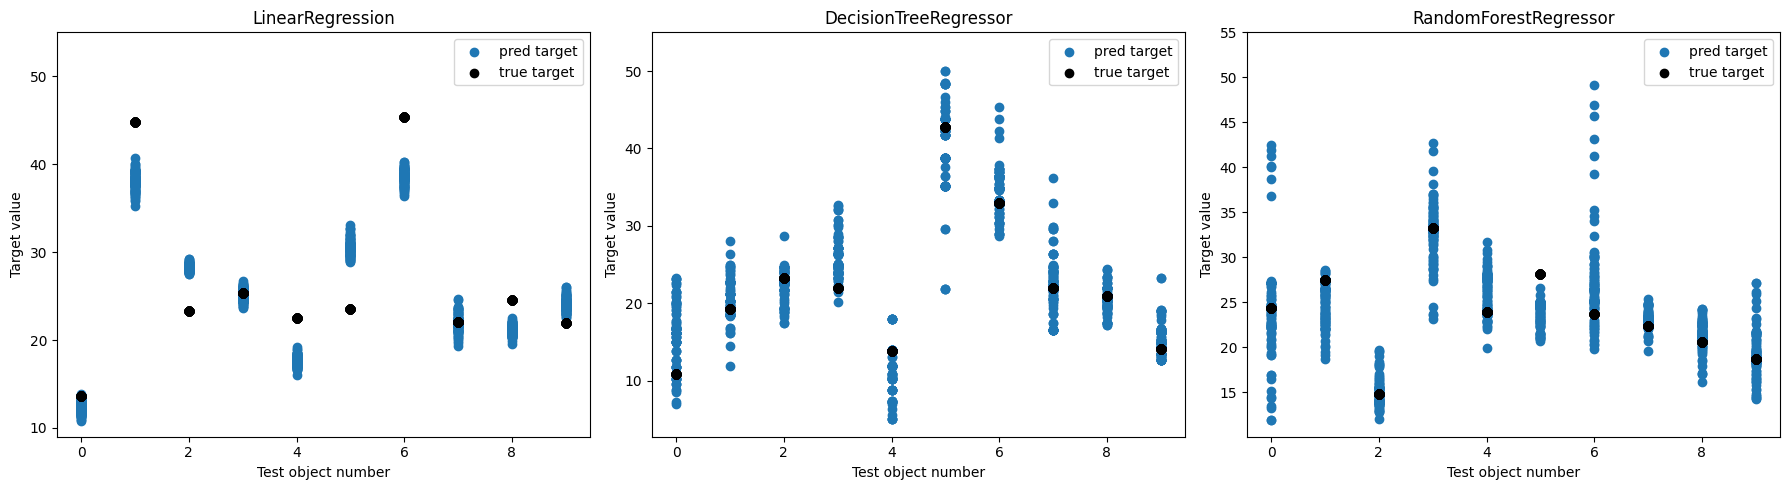

In [50]:
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor(bootstrap=False)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plot_predictions(reg1, X, y, title = "LinearRegression")
plt.ylim(top=y.max()*1.1)
plt.subplot(1, 3, 2)
plot_predictions(reg2, X, y, title = "DecisionTreeRegressor")
plt.ylim(top=y.max()*1.1)
plt.subplot(1, 3, 3)
plot_predictions(reg3, X, y, title = "RandomForestRegressor")
plt.ylim(top=y.max()*1.1)
None

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__

На графике с линейной ригрессии, можем заметить, что предсказания имеют небольшой разброс, но большой сдвиг относительно истинного значения.

На графике с решающим деревом можем наблюдать обратную картину, небольшой сдвиг, но довольно-таки большой разброс.

На графике со случайным лесом можем наблюдать, как влияет большое количество деревьев на разброс, он стал намного меньше относительно одного решающега дерева, а сдвиг не изменился относительно одного дерева.

В итоге можем наблюдать экспериментальное подтверждение тому, что мы обсуждали на занятиях.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [54]:
max_depths = np.arange(1, 11, 1, dtype=int)
max_features_list = np.arange(1, X.shape[1]+1, 1, dtype=int)
bias_max_depth = []
var_max_depth = []
bias_max_features = []
var_max_features = []

for max_depth in max_depths:
  t_reg = DecisionTreeRegressor(max_depth=max_depth)
  bias, var, loss = compute_biase_variance(t_reg, X, y)
  bias_max_depth.append(bias)
  var_max_depth.append(var)

for max_features in max_features_list:
  t_reg = DecisionTreeRegressor(max_features=max_features)
  bias, var, loss = compute_biase_variance(t_reg, X, y)
  bias_max_features.append(bias)
  var_max_features.append(var)

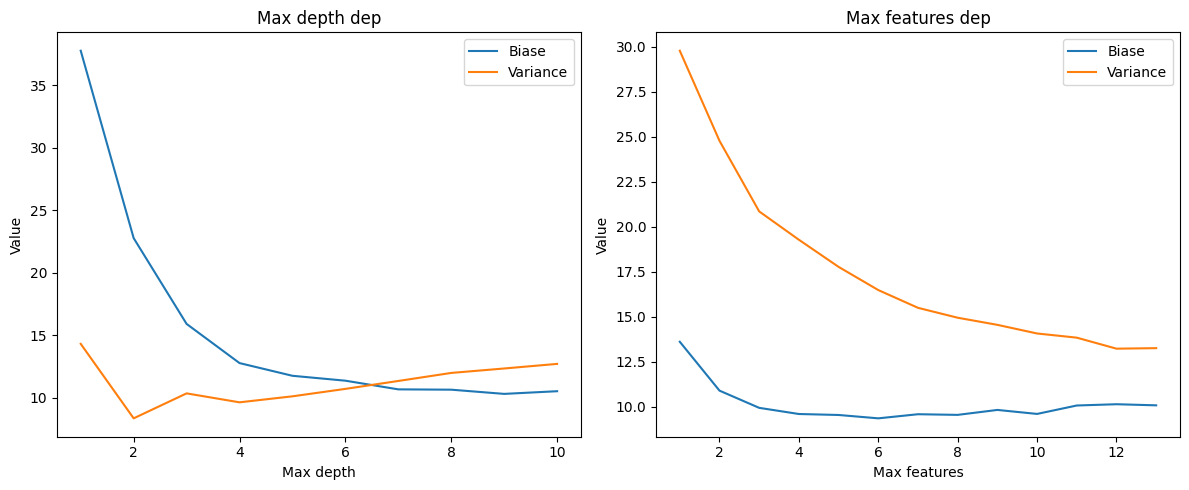

In [60]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(max_depths, bias_max_depth, label="Biase")
plt.plot(max_depths, var_max_depth, label="Variance")
plt.xlabel("Max depth")
plt.ylabel("Value")
plt.title("Max depth dep")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(max_features_list, bias_max_features, label="Biase")
plt.plot(max_features_list, var_max_features, label="Variance")
plt.xlabel("Max features")
plt.ylabel("Value")
plt.title("Max features dep")
plt.legend()

plt.tight_layout()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

In [73]:
n_estimators_list = [2**i for i in range(1, 10)]
bias_frst = []
var_frst = []
bias_boosting = []
var_boosting = []

for n_estimators in n_estimators_list:
  t_frst = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, bootstrap=False)
  t_boost = GradientBoostingRegressor(n_estimators=n_estimators)
  bias_1, var_1, loss_1 = compute_biase_variance(t_frst, X, y)
  bias_2, var_2, loss_2 = compute_biase_variance(t_boost, X, y)
  bias_frst.append(bias_1)
  var_frst.append(var_1)
  bias_boosting.append(bias_2)
  var_boosting.append(var_2)
  print(f"{n_estimators} done")

2 done
4 done
8 done
16 done
32 done
64 done
128 done
256 done
512 done


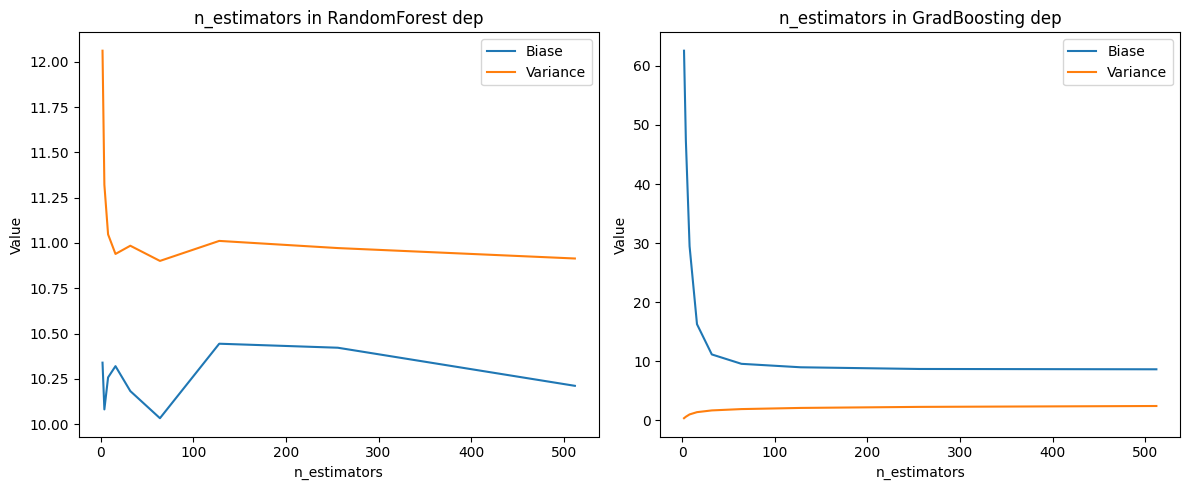

In [74]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators_list, bias_frst, label="Biase")
plt.plot(n_estimators_list, var_frst, label="Variance")
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.title("n_estimators in RandomForest dep")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(n_estimators_list, bias_boosting, label="Biase")
plt.plot(n_estimators_list, var_boosting, label="Variance")
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.title("n_estimators in GradBoosting dep")
plt.legend()

plt.tight_layout()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

График зависимости максимальной глубины так выглядит, видимо потому что, начиная с какого-то момента глубина становится излишней и модель переобучается из-за чего начинает расти разброс, что касаемо максимального числа фичей, то тут можем видеть, что чем больше модель видит данных, тем лучше она их понимает и от этого падает общая ошибка, но опять-таки начиная с некоторого значения, значние ошибки начинает колебаться

На графиках числа естиматоров, можем видеть интересную картину, для случайного леса разброс на несколько пунктов падает до поры до времени, но в начале можем видеть скачки значений ошибки, что может сигнализировать о скором переобучении, что можем видеть, когда сдвиг и разброс выросли
Для бустинга график выглядит стабильнее, сдвиг не увеличивается (как и говорили на лекции), но разброс, на удивление, немного подрастает, но все равно доходит до какой-то ассимптоты и дальше не растет.

Можем сделать вывод, что стоит подбирать гиперпараметры более внимательно и не забывать о bvd

__11.(0 баллов, но может поднять настроение проверяющему и добавить плюсик к к
карме)__

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

__Your answer here:__


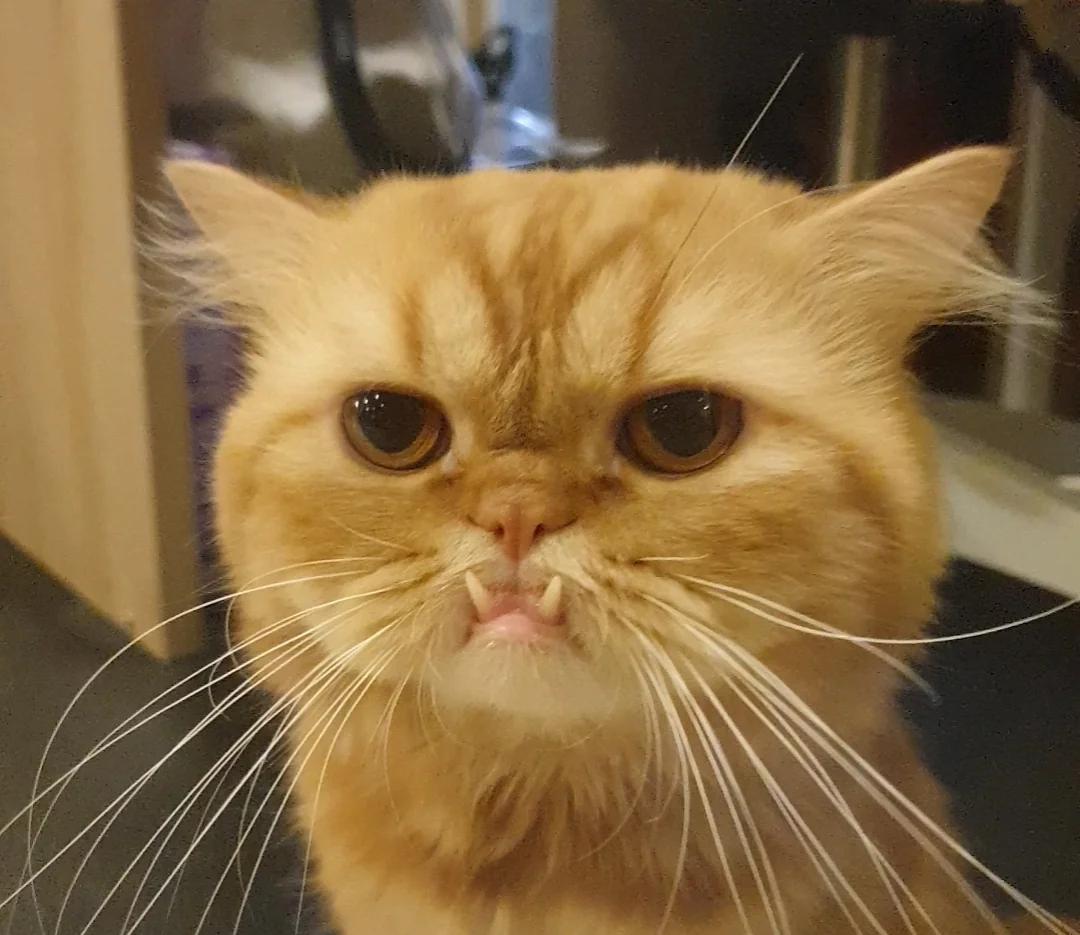